In [1]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 210 kB 41.0 MB/s 
     |████████████████████████████████| 81 kB 8.5 MB/s 
     |████████████████████████████████| 78 kB 5.4 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 150 kB 63.7 MB/s 
     |████████████████████████████████| 113 kB 64.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=114ec1f06e5e54497688230b60b0d4be7c9d415391921437f58bc28eca81761c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
!pip install shap

     |████████████████████████████████| 564 kB 4.3 MB/s 


In [3]:
import pandas as pd
import numpy as np

import copy
import pickle
from datetime import datetime

import xgboost as xgb
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import median_absolute_error as MAPE
from sklearn.metrics import r2_score  as R2
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

from sklearn.metrics import r2_score

# Parameter tunning
import optuna
from sklearn.model_selection import KFold

import shap

from google.colab import drive

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

Version: 1

Data description:
- 1127 postcodes
- Google POI + EPC statistics + Property Data

Goal: sqf prices

In [4]:
# Execute this cell paste the Key, and press the key ENTER...
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
Data = pd.read_csv('/content/drive/My Drive/UKBenEstate/datasetV6.csv') 

In [6]:
len(Data)

1127

In [7]:
list(Data.columns)

['Unnamed: 0',
 'postcode',
 'synagogue_rating_mean_1500',
 'synagogue_rating_std_1500',
 'synagogue_count_1500',
 'synagogue_rating_mean_1000',
 'synagogue_rating_std_1000',
 'synagogue_count_1000',
 'synagogue_rating_mean_500',
 'synagogue_rating_std_500',
 'synagogue_count_500',
 'synagogue_min',
 'shopping_mall_rating_mean_1500',
 'shopping_mall_rating_std_1500',
 'shopping_mall_count_1500',
 'shopping_mall_rating_mean_1000',
 'shopping_mall_rating_std_1000',
 'shopping_mall_count_1000',
 'shopping_mall_rating_mean_500',
 'shopping_mall_rating_std_500',
 'shopping_mall_count_500',
 'shopping_mall_min',
 'secondary_rating_mean_1500',
 'secondary_rating_std_1500',
 'secondary_count_1500',
 'secondary_rating_mean_1000',
 'secondary_rating_std_1000',
 'secondary_count_1000',
 'secondary_rating_mean_500',
 'secondary_rating_std_500',
 'secondary_count_500',
 'secondary_min',
 'school_rating_mean_1500',
 'school_rating_std_1500',
 'school_count_1500',
 'school_rating_mean_1000',
 'school

### Crime

In [8]:
Data['crime_total']=Data['PublicOrder']+Data['Burglary']+Data['Robbery']+Data['PossessionOfWeapons']+Data['BicycleTheft']+Data['AntiSocialBehaviour']+Data['Violence']+Data['Theft']+Data['Shoplifting']+Data['OtherCrime']+Data['Drugs']+Data['OtherTheft']+Data['VehicleCrime']+Data['CriminalDamage']

In [9]:
Data['PublicOrder']=Data['PublicOrder']/Data['crime_total']

In [10]:
Data['Burglary'] = Data['Burglary']/Data['crime_total']
Data['Robbery'] = Data['Robbery']/Data['crime_total']
Data['PossessionOfWeapons'] = Data['PossessionOfWeapons']/Data['crime_total']
Data['BicycleTheft'] = Data['BicycleTheft']/Data['crime_total']
Data['AntiSocialBehaviour'] = Data['AntiSocialBehaviour']/Data['crime_total']
Data['Violence'] = Data['Violence']/Data['crime_total']
Data['Theft'] = Data['Theft']/Data['crime_total']
Data['Shoplifting'] = Data['Shoplifting']/Data['crime_total']
Data['OtherCrime'] = Data['OtherCrime']/Data['crime_total']
Data['Drugs'] = Data['Drugs']/Data['crime_total']
Data['OtherTheft'] = Data['OtherTheft']/Data['crime_total']
Data['VehicleCrime'] = Data['VehicleCrime']/Data['crime_total']
Data['CriminalDamage'] = Data['CriminalDamage']/Data['crime_total']

Data['crime_Type_A'] = Data['Robbery']+Data['Drugs']+Data['PossessionOfWeapons']+Data['Burglary']+Data['OtherCrime']
Data['crime_Type_B'] = Data['OtherTheft'] + Data['Shoplifting'] + Data['Theft'] + Data['BicycleTheft']
Data['crime_Type_C'] = Data['CriminalDamage']+ Data['Violence'] + Data['AntiSocialBehaviour']
Data['crime_Type_D'] = Data['VehicleCrime']

In [11]:
dropList=['Burglary',
 'Robbery',
 'PossessionOfWeapons',
 'BicycleTheft',
 'AntiSocialBehaviour',
 'Violence',
 'Theft',
 'Shoplifting',
 'OtherCrime',
 'Drugs',
 'OtherTheft',
 'VehicleCrime',
 'CriminalDamage',]
Data.drop(dropList, axis = 1, inplace = True)

### Age 

error: age55_59 age65-69

In [12]:
Data['TotalModPop'] = Data['age20_24']+Data['age25_29']+Data['age30_34']+Data['age35_39']+Data['age40_44']+Data['age45_49']+Data['age45_49']+Data['age50_54']+Data['age60_64']
Data['age20_29'] = Data['age20_24']+Data['age25_29']
Data['age30_64'] = Data['age30_34']+Data['age35_39']+Data['age40_44']+Data['age45_49']+Data['age50_54']+Data['age60_64']
Data['age65_'] = Data['age70_74']+Data['age75_79']+Data['age80_84']+Data['age85_89']

In [13]:
dropList=['age20_24',
 'age25_29',
 'age30_34',
 'age35_39',
 'age40_44',
 'age45_49',
 'age50_54',
 'age60_64',
 'age70_74',
 'age75_79',
 'age80_84',
 'age85_89']
Data.drop(dropList, axis = 1, inplace = True)

In [14]:
Data['commute_method_public'] = Data['commute_method_train'] + Data['commute_method_bus'] + Data['commute_method_underground_light_rail']
Data['commute_method_private'] = Data['commute_method_motorcycle'] + Data['commute_method_taxi'] + Data['commute_method_car_driver'] + Data['commute_method_car_passenger']
Data['commute_method_open'] = Data['commute_method_foot']+Data['commute_method_bicycle']

In [15]:
dropList=['commute_method_foot',
 'commute_method_bicycle',
 'commute_method_other',
 'commute_method_motorcycle',
 'commute_method_taxi',
 'commute_method_train',
 'commute_method_bus',
 'commute_method_underground_light_rail',
 'commute_method_car_driver',
 'commute_method_at_home',
 'commute_method_car_passenger',
]
Data.drop(dropList, axis = 1, inplace = True)

In [16]:
dropList=[ 'dyn_sold_points_analysed',
 'dyn_sold_70pc_rangeMIN',
 'dyn_sold_70pc_rangeMAX',
 'dyn_sold_80pc_rangeMIN',
 'dyn_sold_80pc_rangeMAX',
 'dyn_sold_90pc_rangeMIN',
 'dyn_sold_90pc_rangeMAX',
 'dyn_sold_sqf_points_analysed',
 'dyn_sold_sqf_70pc_rangeMIN',
 'dyn_sold_sqf_70pc_rangeMAX',
 'dyn_sold_sqf_80pc_rangeMIN',
 'dyn_sold_sqf_80pc_rangeMAX',
 'dyn_sold_sqf_90pc_rangeMIN',
 'dyn_sold_sqf_90pc_rangeMAX',
 'dyn_rents_points_analysed',
 'dyn_rents_70pc_rangeMIN',
 'dyn_rents_70pc_rangeMAX',
 'dyn_rents_80pc_rangeMIN',
 'dyn_rents_80pc_rangeMAX',
 'dyn_rents_90pc_rangeMIN',
 'dyn_rents_90pc_rangeMAX',]
Data.drop(dropList, axis = 1, inplace = True)

In [17]:
### POI 


In [18]:
Data['HperP']=Data['Households']/Data['Population']

In [19]:
#Data['construction_before_1950']=(Data['construction_before_1900'] + Data['construction_1900_1929'] + Data['construction_1930_1949']) 
#Data['construction_1950_1975']=(Data['construction_1950_1966']+Data['construction_1967_1975']+ Data['construction_1976_1982'])
#Data['construction_1983_1990']=(Data['construction_1983_1990']+Data['construction_1991_1995'])
#Data['construction_1996_2006']=(Data['construction_1996_2002']+Data['construction_2003_2006'])
#Data['construction_2007_onwards']=(Data['construction_2007_2011']+Data['construction_2012_onwards'])

In [20]:
dropList=['construction_before_1900',
 'construction_1900_1929',
 'construction_1930_1949',
 'construction_1950_1966',
 'construction_1967_1975',
 'construction_1976_1982',
 'construction_1983_1990',
 'construction_1991_1995',
 'construction_1996_2002',
 'construction_2003_2006',
 'construction_2007_2011',
 'construction_2012_onwards']
#Data.drop(dropList, axis = 1, inplace = True)

No handles with labels found to put in legend.


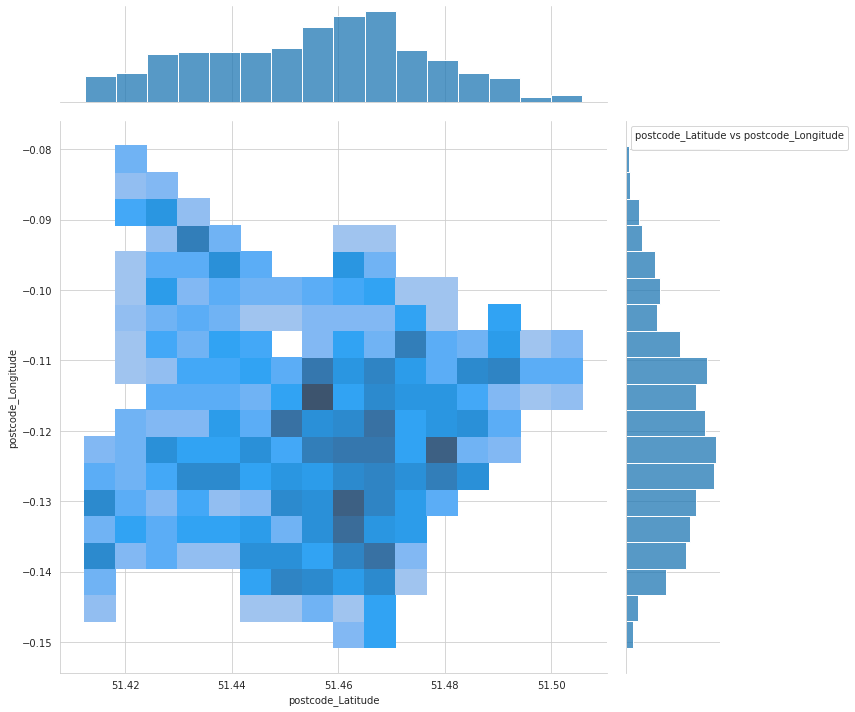

In [21]:
sns.set_style('whitegrid')
sns.jointplot(x ='postcode_Latitude', y ='postcode_Longitude', data = Data, kind ='hist',height=10)
plt.legend(title='postcode_Latitude vs postcode_Longitude')

No handles with labels found to put in legend.


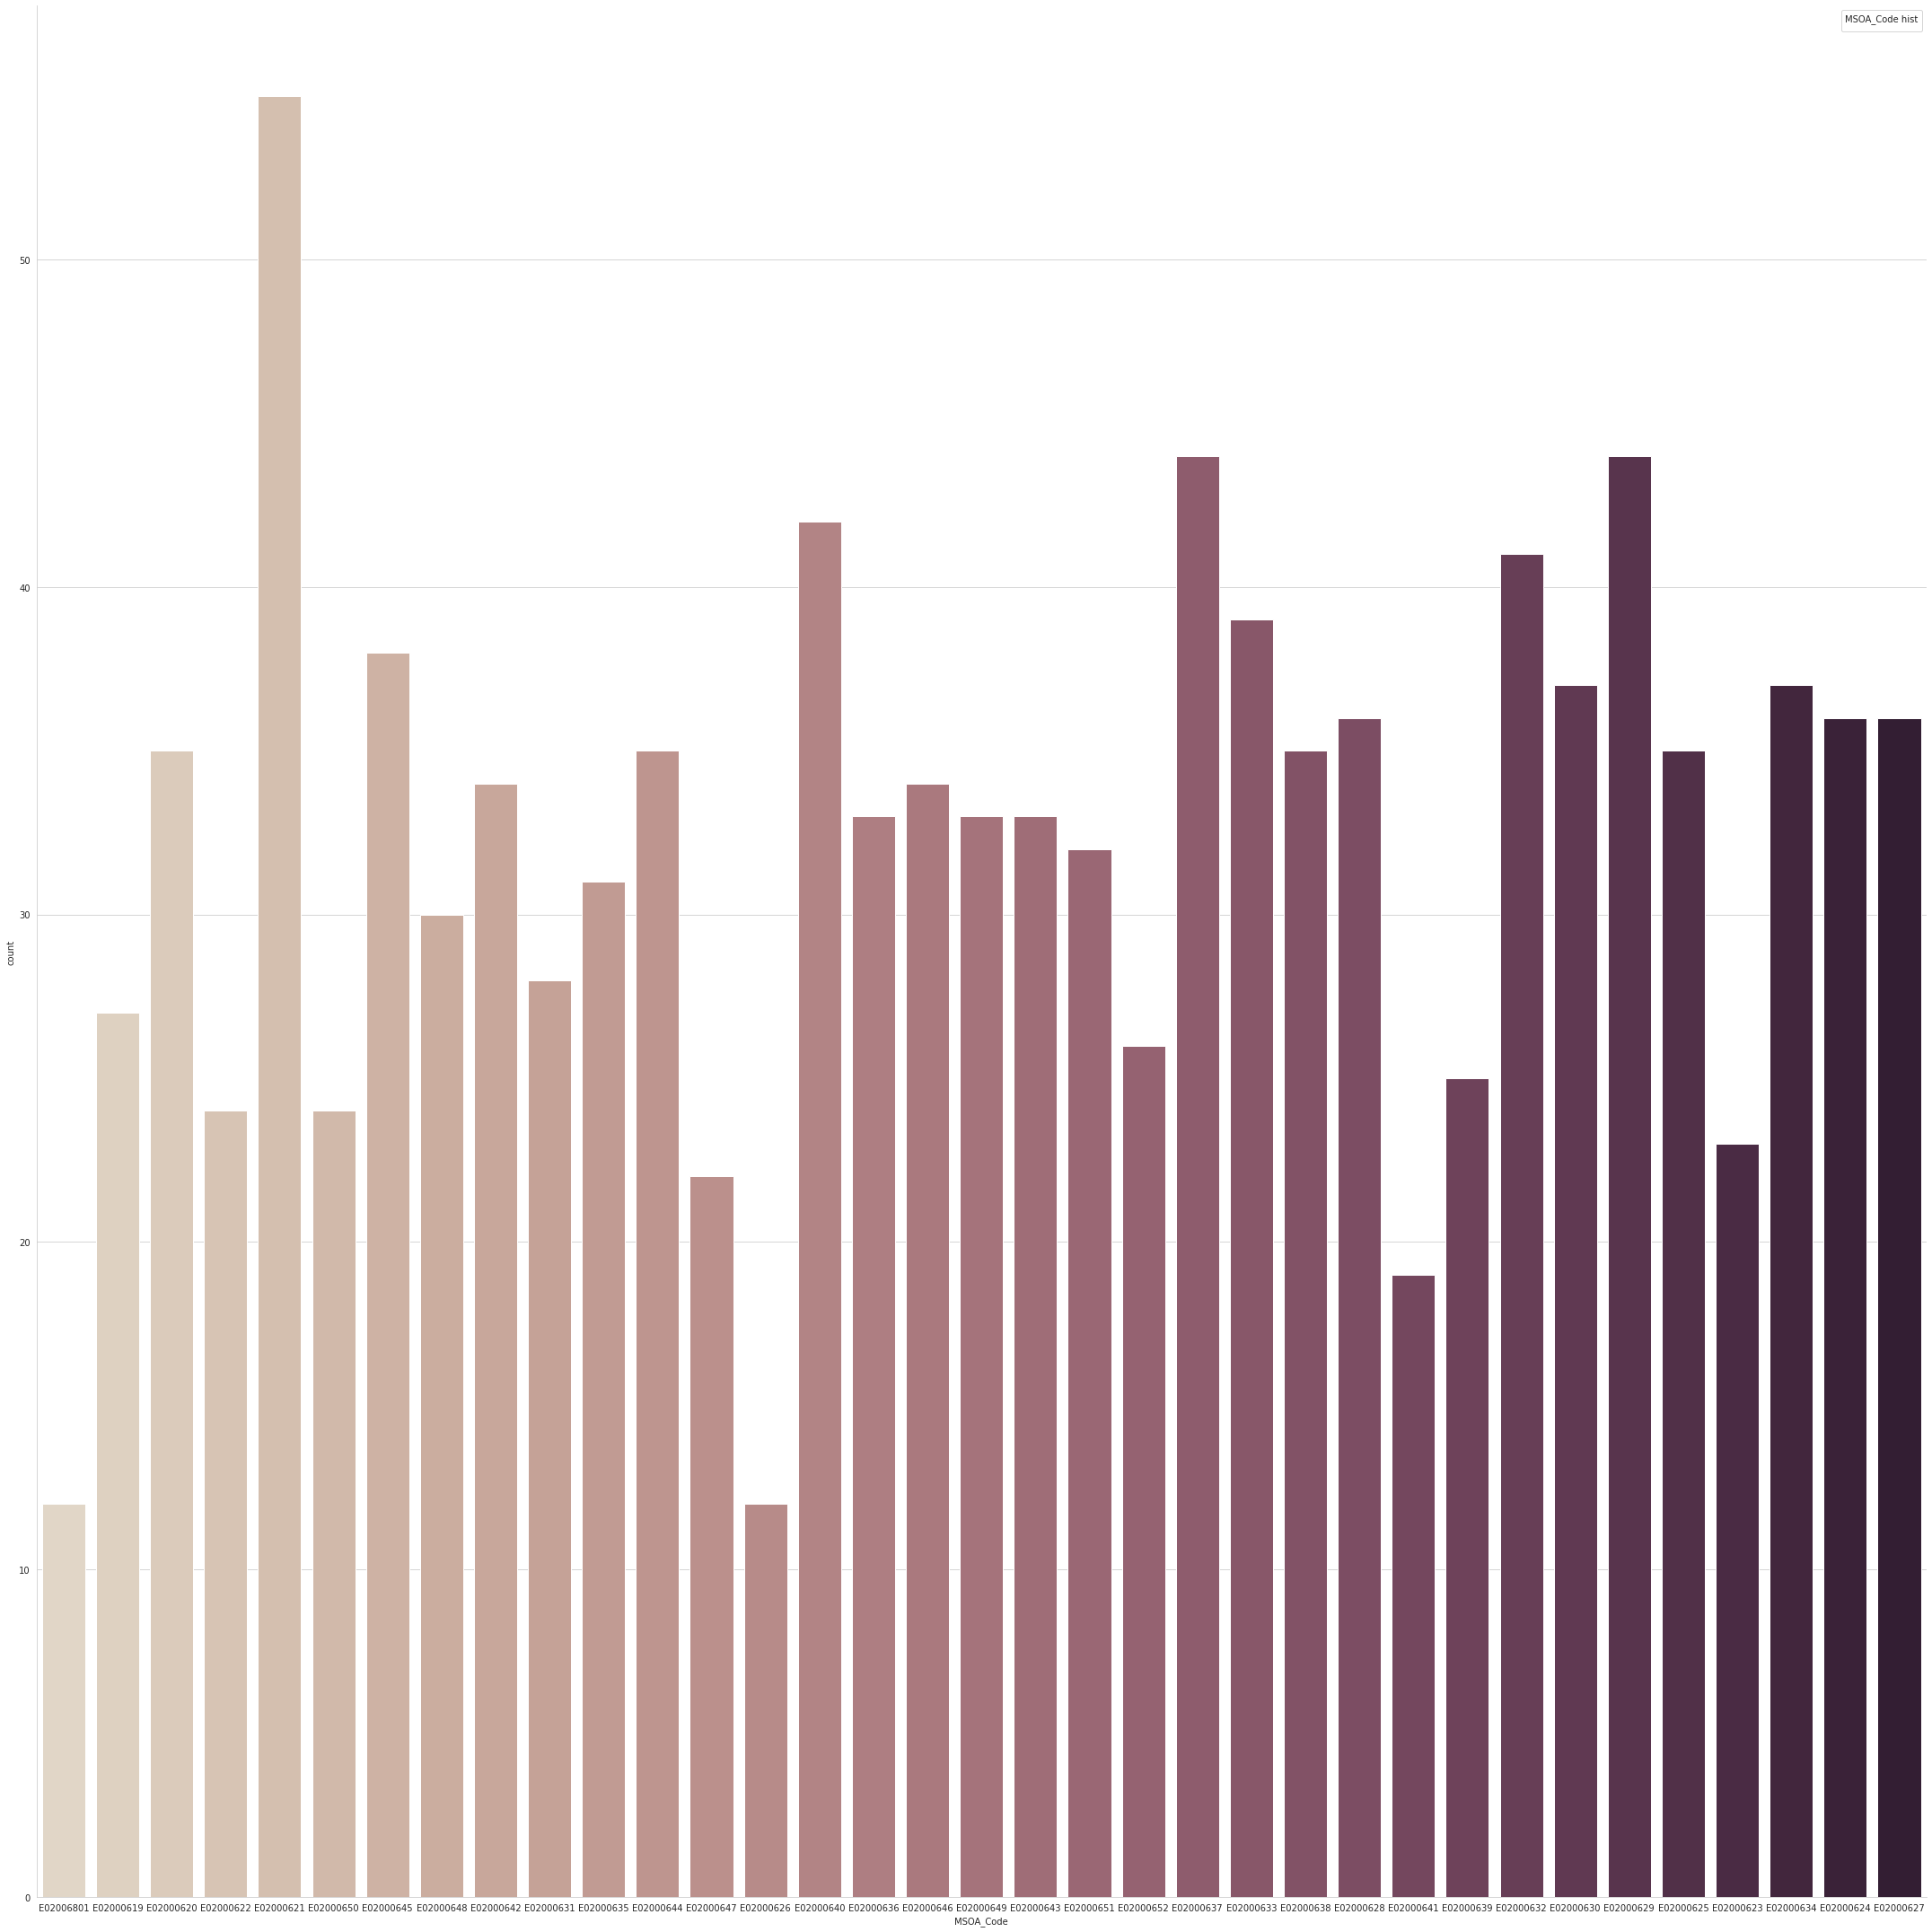

In [22]:
sns.set_style('whitegrid')
sns.catplot(x="MSOA_Code", kind="count", palette="ch:.25", data=Data, height=30)
plt.legend(title='MSOA_Code hist')

No handles with labels found to put in legend.


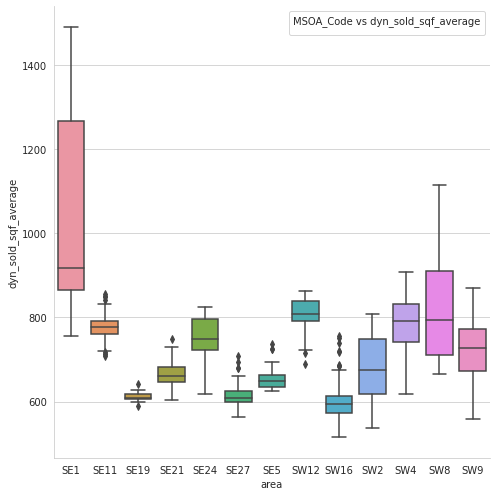

In [23]:
sns.catplot(x="area", y="dyn_sold_sqf_average",  kind="box", data=Data,height=7)
plt.legend(title='MSOA_Code vs dyn_sold_sqf_average')

No handles with labels found to put in legend.


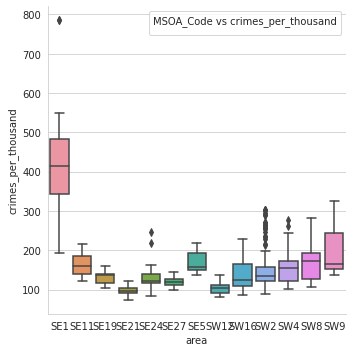

In [24]:
sns.catplot(x="area", y="crimes_per_thousand",  kind="box", data=Data)
plt.legend(title='MSOA_Code vs crimes_per_thousand')

Removing inrelevant attributes

In [25]:
dropList=['Unnamed: 0','postcode','count',
         'postcode_Latitude','postcode_Longitude','MSOA_Code','LSOA_Code','area'
          ]
Data.drop(dropList, axis = 1, inplace = True)

In [26]:
dropList=['dyn_sold_average',
 'dyn_sold_100pc_rangeMIN',
 'dyn_sold_100pc_rangeMAX',
 'dyn_sold_sqf_100pc_rangeMIN',
 'dyn_sold_sqf_100pc_rangeMAX',
 'dyn_rents_average',
 'dyn_rents_100pc_rangeMIN',
 'dyn_rents_100pc_rangeMAX',
         ]
Data.drop(dropList, axis = 1, inplace = True)

Adding the price paid by sq

No handles with labels found to put in legend.


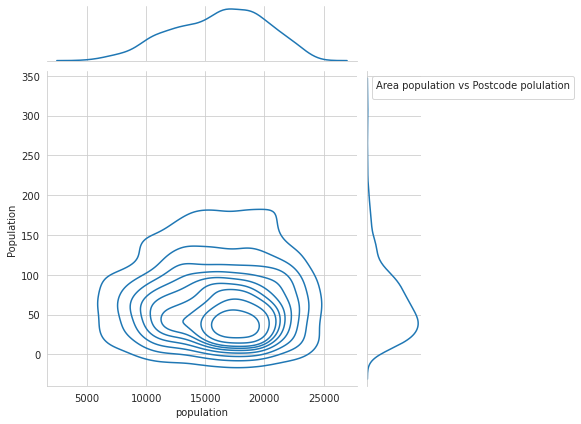

In [27]:
sns.set_style('whitegrid')
sns.jointplot(x ='population', y ='Population', data = Data, kind ='kde')
plt.legend(title='Area population vs Postcode polulation')

No handles with labels found to put in legend.


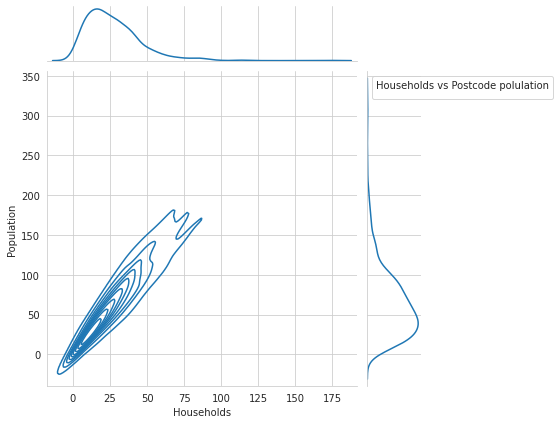

In [28]:
sns.set_style('whitegrid')
sns.jointplot(x ='Households', y ='Population', data = Data, kind ='kde')
plt.legend(title='Households vs Postcode polulation')

sq_PricePaid statistics

In [29]:
Data['dyn_sold_sqf_average'].describe()

count    1127.000000
mean      715.212067
std       108.614389
min       515.000000
25%       626.000000
50%       720.000000
75%       784.000000
max      1491.000000
Name: dyn_sold_sqf_average, dtype: float64

No handles with labels found to put in legend.


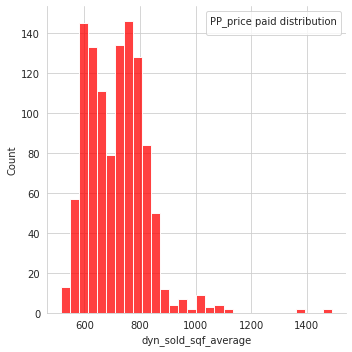

In [30]:
sns.set_style('whitegrid')
sns.displot(Data['dyn_sold_sqf_average'], kde = False, color ='red', bins = 30)
plt.legend(title='PP_price paid distribution')

No handles with labels found to put in legend.


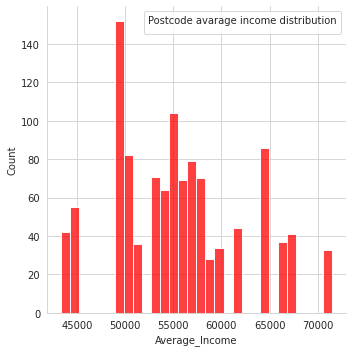

In [31]:
sns.set_style('whitegrid')
sns.displot(Data['Average_Income'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode avarage income distribution')

No handles with labels found to put in legend.


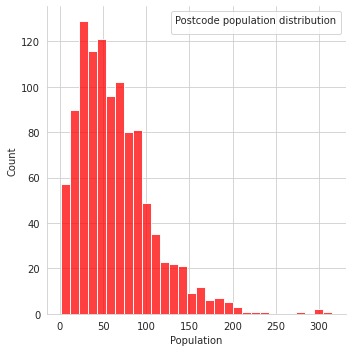

In [32]:
sns.set_style('whitegrid')
sns.displot(Data['Population'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode population distribution')

No handles with labels found to put in legend.


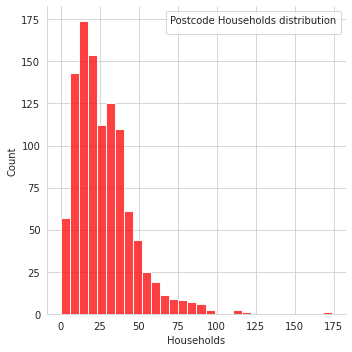

In [33]:
sns.set_style('whitegrid')
sns.displot(Data['Households'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode Households distribution')

No handles with labels found to put in legend.


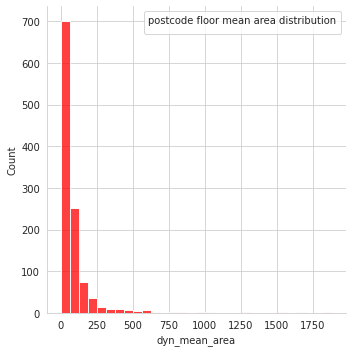

In [34]:
sns.set_style('whitegrid')
sns.displot(Data['dyn_mean_area'], kde = False, color ='red', bins = 30)
plt.legend(title='postcode floor mean area distribution')


 Categorical attribute binarization

In [35]:

lbl = preprocessing.LabelEncoder()

catData = ['dyn_ptal', 'dyn_flood_risk','crime_rating']
for att in catData:
    unique_classes = Data[att].unique()
    one_hot = pd.get_dummies(unique_classes, prefix=att,dummy_na=True, columns = [att])
    one_hot[att] = unique_classes
    Data = Data.merge(one_hot, on = [att], how='left')
    Data = Data.drop(columns = [att])

Define sqf_price as the model goal 

In [36]:
Data['price'] = Data['dyn_sold_sqf_average']
Data.drop(['dyn_sold_sqf_average'], axis = 1, inplace = True)

In [37]:
# Split data
X, y = Data.iloc[:, :-1], Data.iloc[:, -1]


Attributes used for the model

In [ ]:
def objective(trial, X, y, kf):
    n_estimators = trial.suggest_int('n_estimators', 206, 512)
    learning_rate =trial.suggest_uniform('learning_rate', 0, 0.1) 
    #max_depth = trial.suggest_int('max_depth', 3, 10)
    min_split_loss = trial.suggest_uniform('min_split_loss', 0, 2.5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0, 10)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0, 10)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1)
    subsample = trial.suggest_uniform('subsample', 0.5, 1)
    eta = trial.suggest_uniform('eta', 0, 1)
    
    model = xg.XGBRegressor(n_estimators=n_estimators,
                          #max_depth=max_depth,
                          learning_rate=learning_rate,
                          min_split_loss=min_split_loss,
                          min_child_weight=min_child_weight,
                          reg_lambda=reg_lambda,
                          reg_alpha=reg_alpha,
                          colsample_bytree=colsample_bytree,
                          subsample=subsample,
                          eta=eta,
                          objective='reg:squarederror', 
                          booster='gbtree',
                          seed=42,
                          n_jobs=3)
    
    
    test_score = []
    
    step = 0
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        test_score.append(MAE(y_test, y_pred)/715.212067*100)
        #test_score.append(R2(y_test, y_pred))
        
        trial.report(np.mean(test_score), step)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        step+=1

    return np.mean(test_score)



kf = KFold(n_splits=4, shuffle=True, random_state=42)

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.SuccessiveHalvingPruner())

study.optimize(lambda trial: objective(trial, X, y, kf), timeout=30*60, n_jobs=1)

study.best_params 

[I 2022-03-29 03:43:17,814] A new study created in memory with name: no-name-e7262837-0ae7-492a-8b17-be9c9a3a463e
[I 2022-03-29 03:43:34,831] Trial 0 finished with value: 2.532613240261683 and parameters: {'n_estimators': 473, 'learning_rate': 0.09332032562603335, 'min_split_loss': 2.1892347736963247, 'min_child_weight': 8, 'reg_lambda': 9.01296587439667, 'reg_alpha': 9.366254548610879, 'colsample_bytree': 0.926647668482778, 'subsample': 0.9790169496945833, 'eta': 0.7473624389303838}. Best is trial 0 with value: 2.532613240261683.
[I 2022-03-29 03:43:47,103] Trial 1 finished with value: 2.484821248449147 and parameters: {'n_estimators': 498, 'learning_rate': 0.042295299369992795, 'min_split_loss': 1.3391831882507101, 'min_child_weight': 1, 'reg_lambda': 2.5792773616104405, 'reg_alpha': 0.789398025492335, 'colsample_bytree': 0.5771807592689012, 'subsample': 0.711787901346757, 'eta': 0.16778540145649656}. Best is trial 1 with value: 2.484821248449147.
[I 2022-03-29 03:43:51,150] Trial 2 

{'colsample_bytree': 0.6031533778749063,
 'eta': 0.19173407065680925,
 'learning_rate': 0.09369241346546422,
 'min_child_weight': 1,
 'min_split_loss': 2.4042271493468728,
 'n_estimators': 465,
 'reg_alpha': 5.370536851281267,
 'reg_lambda': 0.1684586632551462,
 'subsample': 0.8939839092812706}

In [38]:


# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.2)

In [39]:
model = XGBRegressor(objective='reg:squarederror', 
                     n_estimators= 465,
                     learning_rate= 0.06626130240901489,
                     min_split_loss= 2.4042271493468728,
                     min_child_weight= 1,
                     reg_lambda= 0.1684586632551462,
                     reg_alpha= 5.370536851281267,
                     colsample_bytree= 0.6031533778749063,
                     subsample= 0.8939839092812706,
                     eta= 0.19173407065680925)

xgb_r = model.fit(train_X, train_y)

pred_train = model.predict(train_X)
pred_test = model.predict(test_X)

# MAE Computation
mae =MAE(train_y, pred_train)
print("Train MAE : % f --- %f" %(mae,mae/715.212067*100),"%")
# MAE Computation
mae =MAE(test_y, pred_test)
print("Test MAE : % f --- %f" %(mae,mae/715.212067*100),"%")

# MAE Computation
mape =MAPE(train_y, pred_train)
print("Train MAPE : % f --- %f" %(mape,mape/715.212067*100),"%")
# MAE Computation
mape =MAPE(test_y, pred_test)
print("Test MAPE : % f --- %f" %(mape,mape/715.212067*100),"%")

# MAE Computation
r2 =R2(train_y, pred_train)
print("Train R2 : % f" %(r2))
# MAE Computation
r2 =R2(test_y, pred_test)
print("Test R2 : % f" %(r2))

Train MAE :  4.610314 --- 0.644608 %
Test MAE :  17.871454 --- 2.498763 %
Train MAPE :  3.777344 --- 0.528143 %
Test MAPE :  12.823761 --- 1.793001 %
Train R2 :  0.996974
Test R2 :  0.944796


No handles with labels found to put in legend.


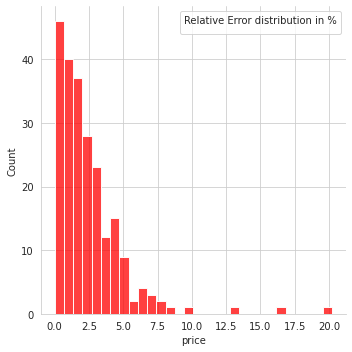

In [40]:
sns.set_style('whitegrid')
sns.displot( abs(test_y-pred_test)/test_y*100, kde = False, color ='red', bins = 30)
plt.legend(title='Relative Error distribution in %')

Cross validation

In [41]:
# define model

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
# MAE Computation
print("CV MAE £: " ,scores.mean(), scores.mean()/409.968944*100," % --- std £",scores.std())

CV MAE £:  16.20106715456725 3.9517791266080025  % --- std £ 1.7177775108511828


In [42]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)

# R2 Computation
print("CV R2 :" ,scores.mean(), " std:",scores.std())

CV R2 : 0.9477695788676254  std: 0.017661379522332155


### Plot feature importance

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

- The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. 
- The Coverage metric means the relative number of observations related to this feature.
- The Weight  is the percentage representing the relative number of times a particular feature occurs in the trees of the model
- ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 
- ‘Coverage’ measures the relative quantity of observations concerned by a feature.”


#### Ranking by gain (uses the loss)

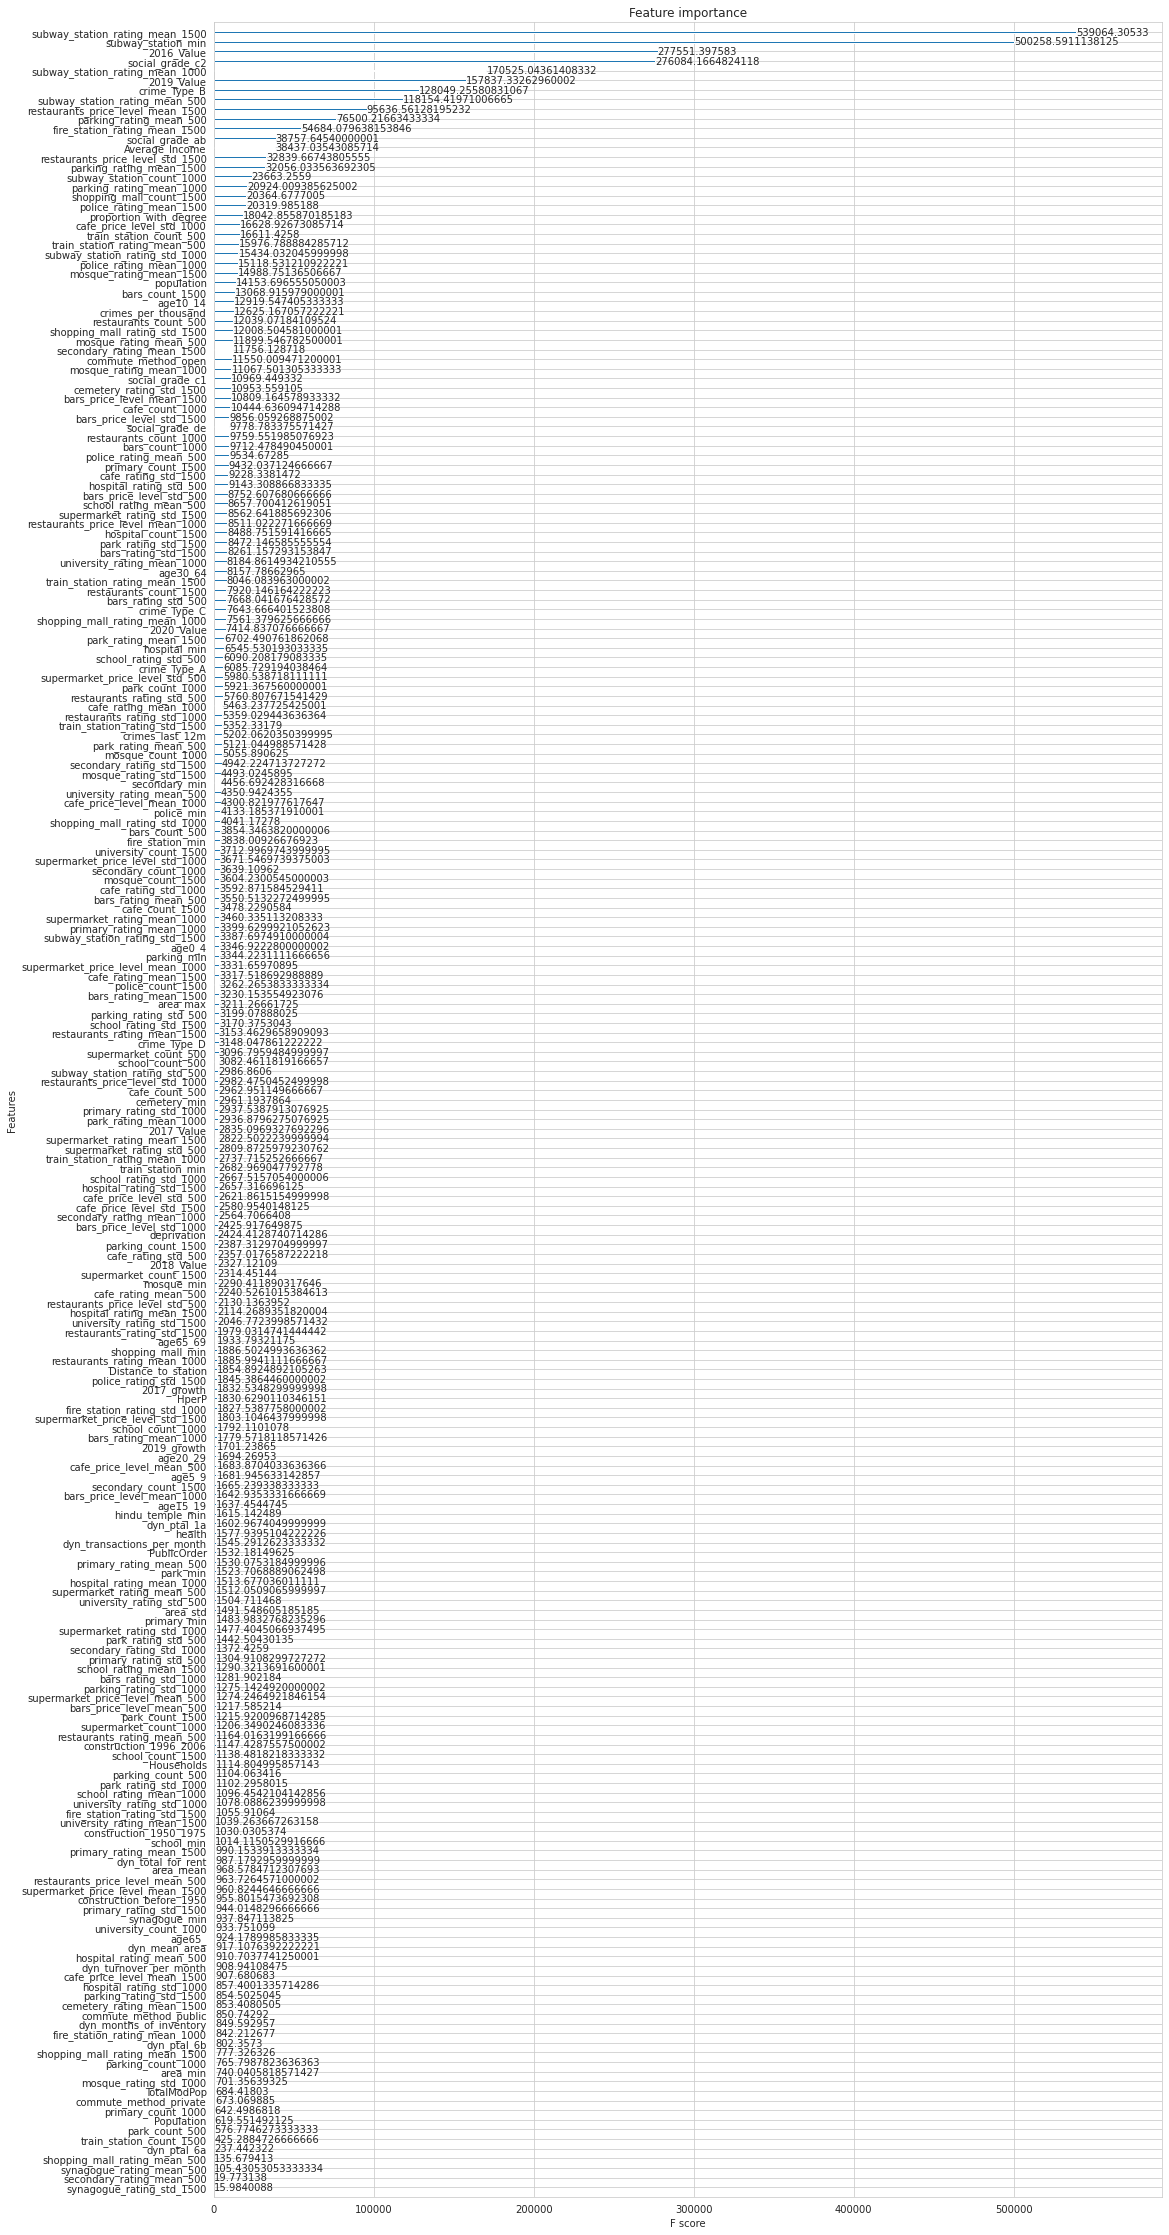

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='gain')

#### Ranking by cover

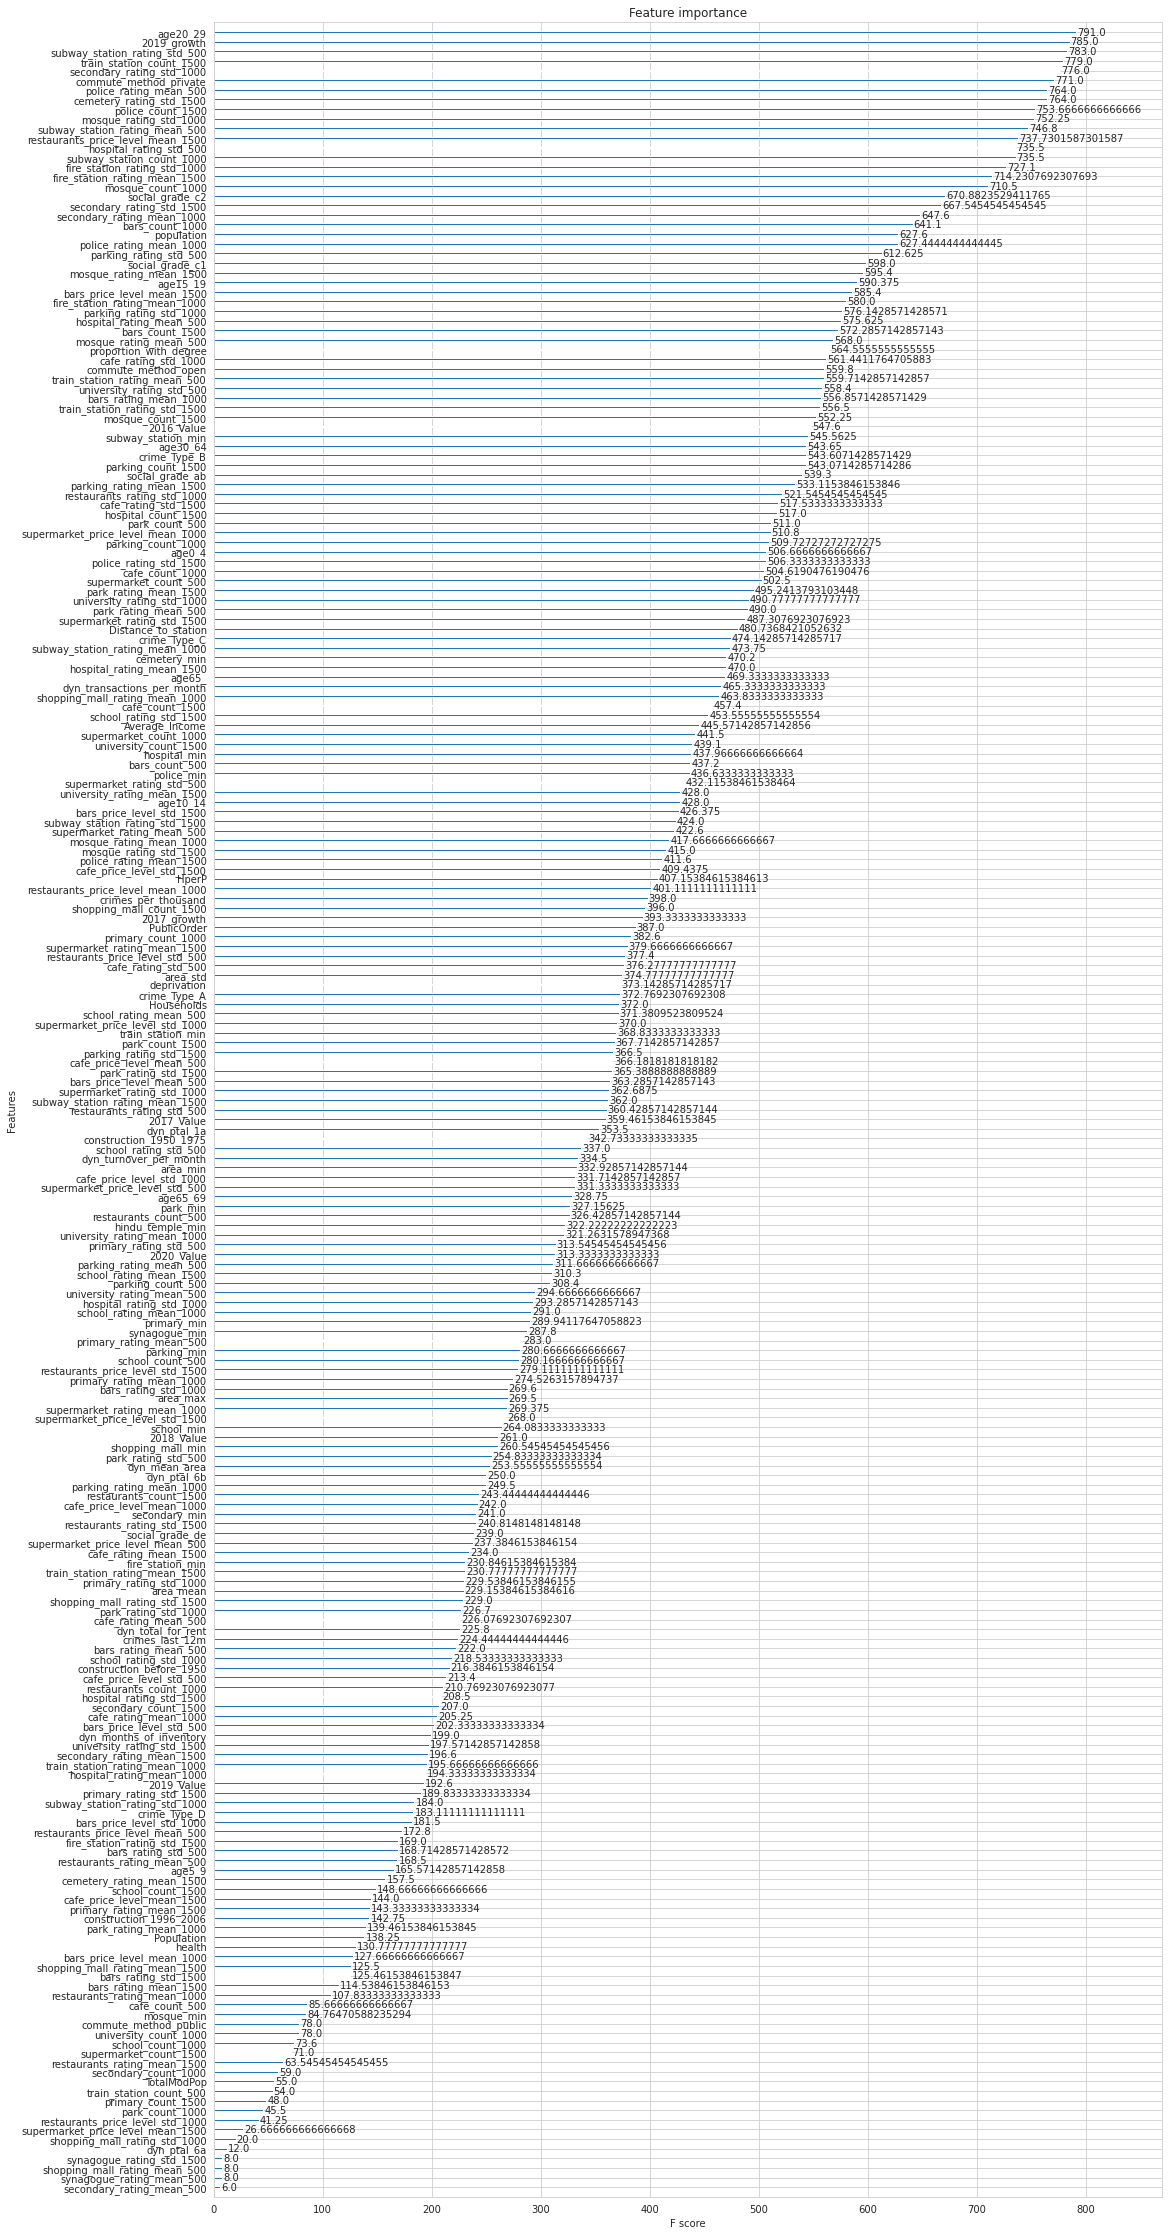

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='cover')

#### Ranking by total gain

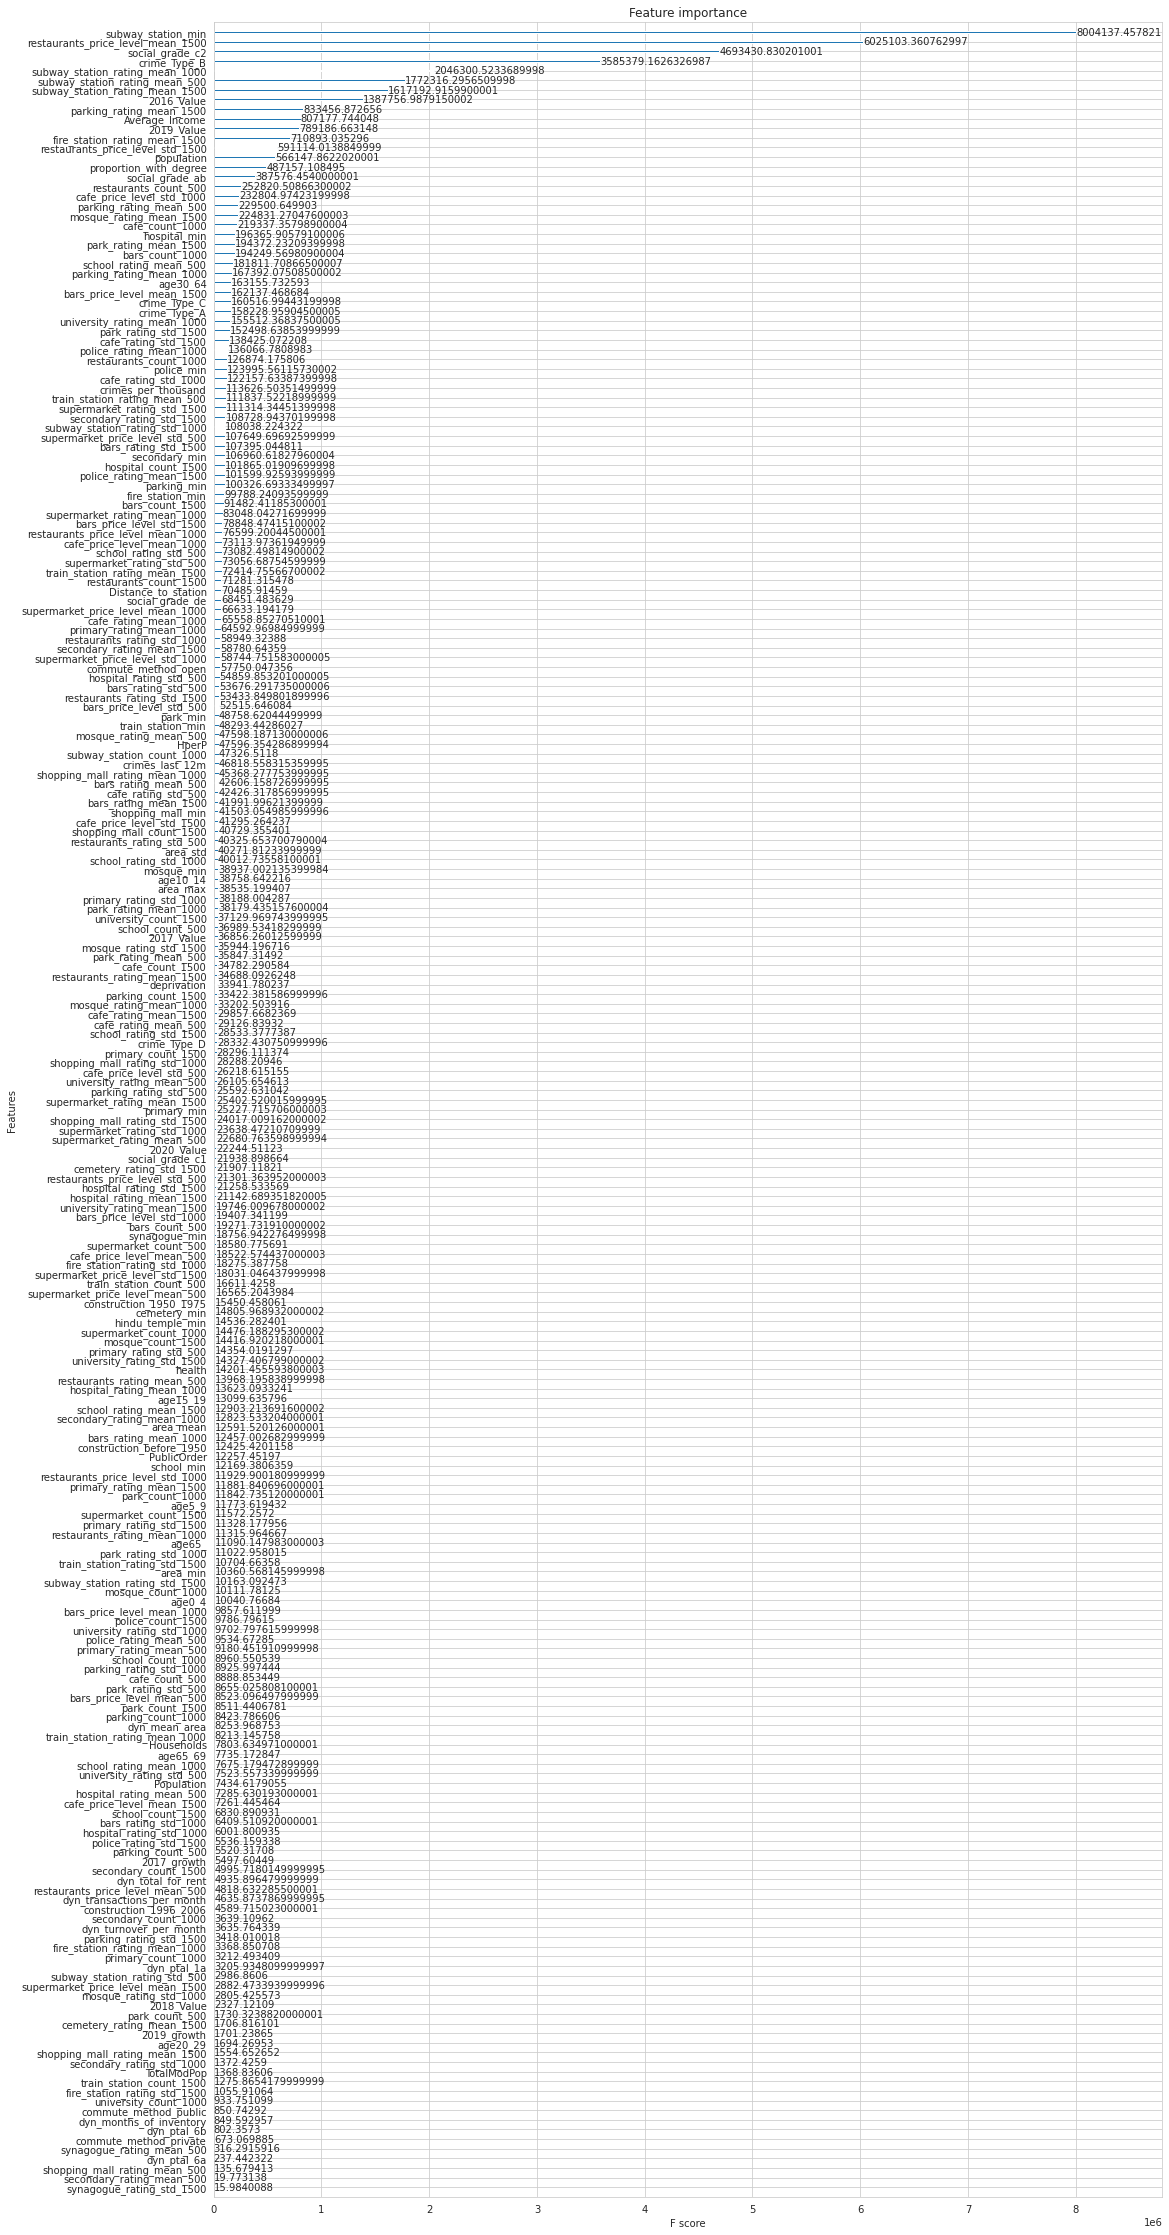

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='total_gain')

#### Ranking by total cover (uses the total loss)

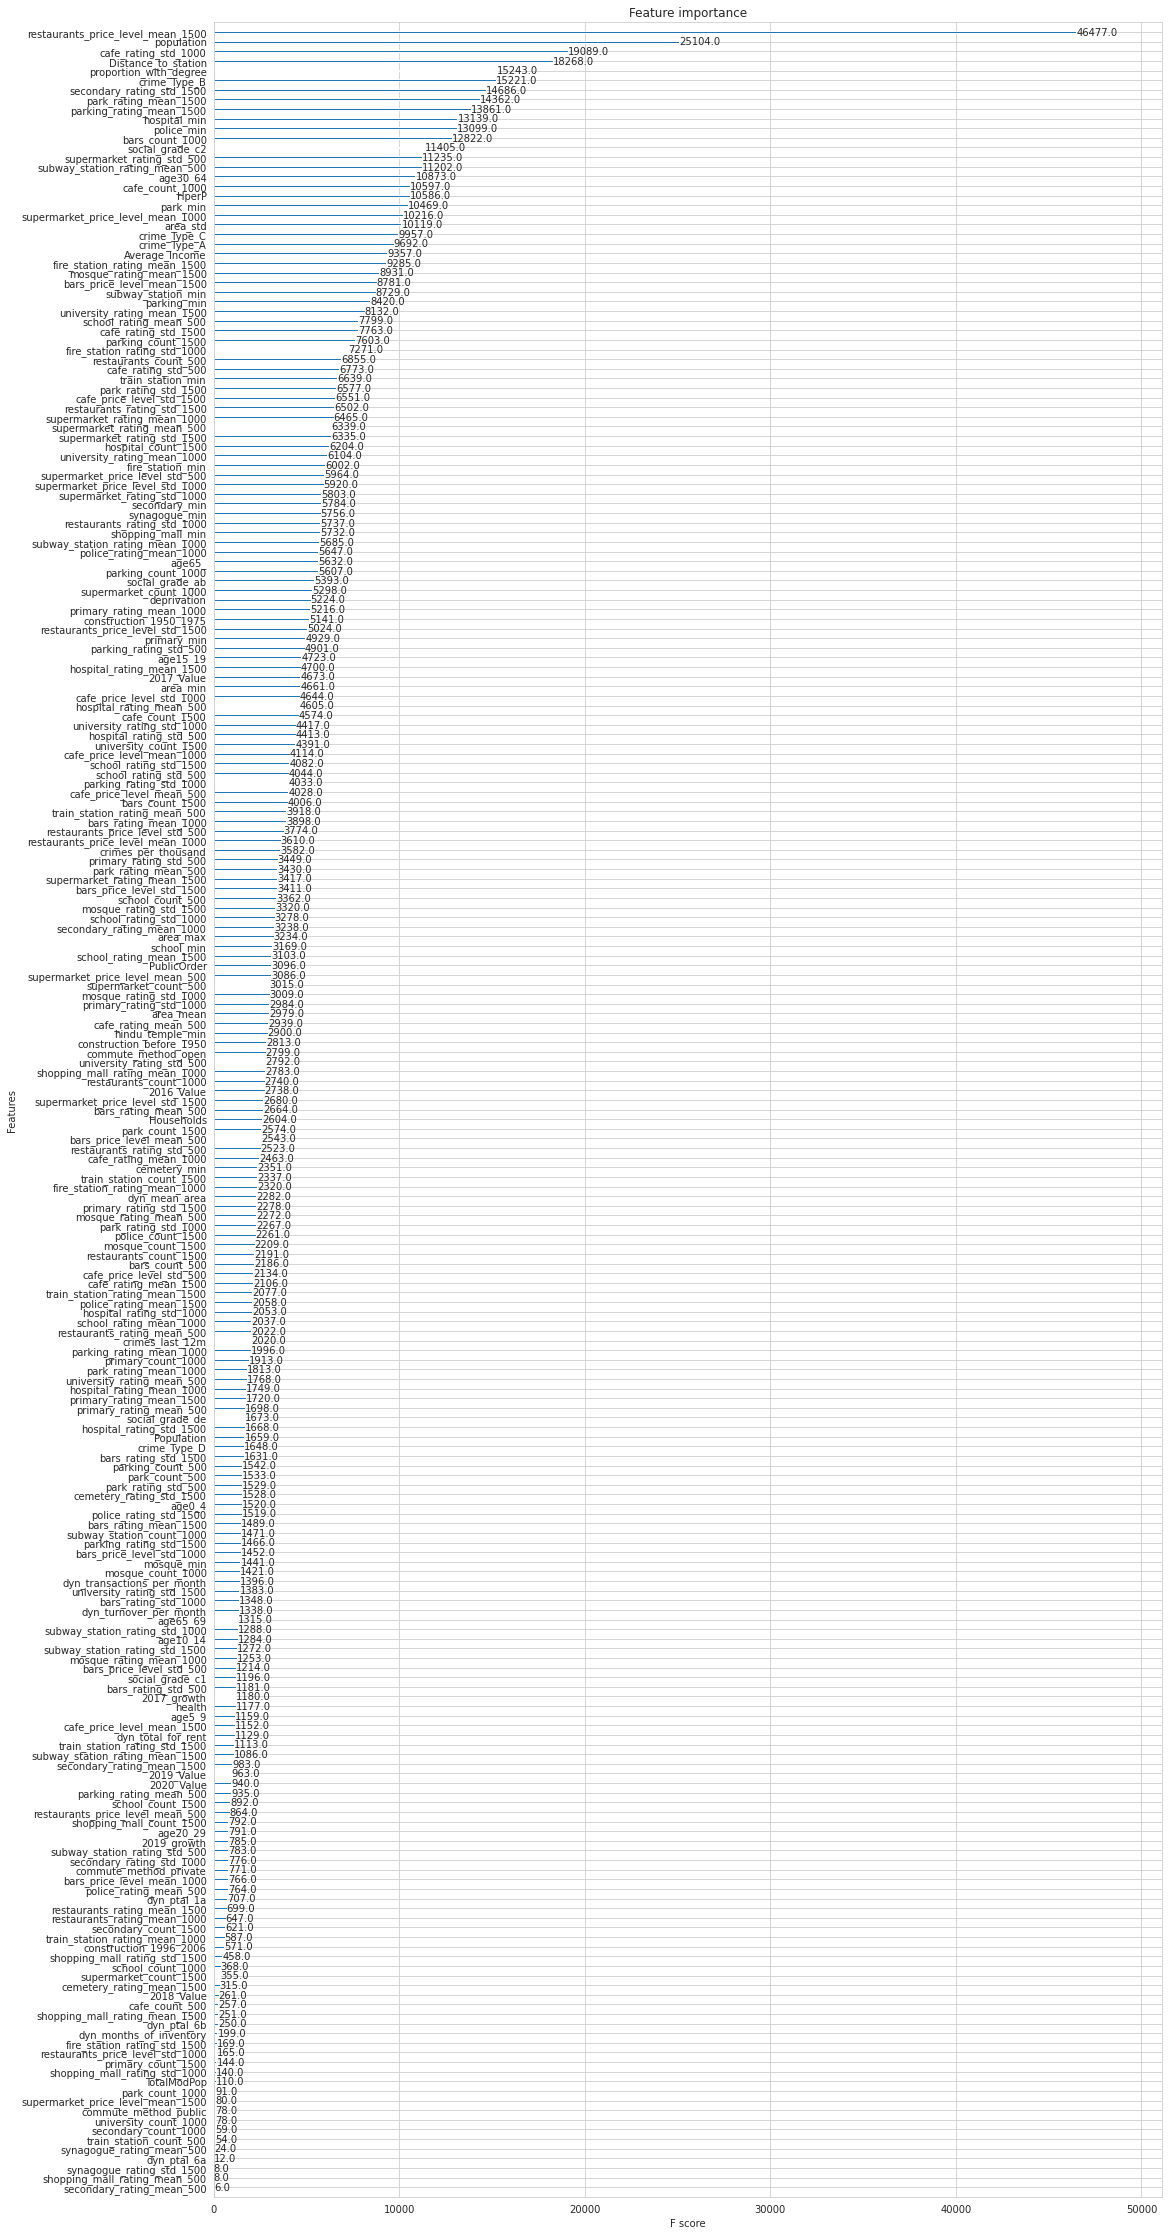

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax,importance_type='total_cover')

#### Ranking by weight

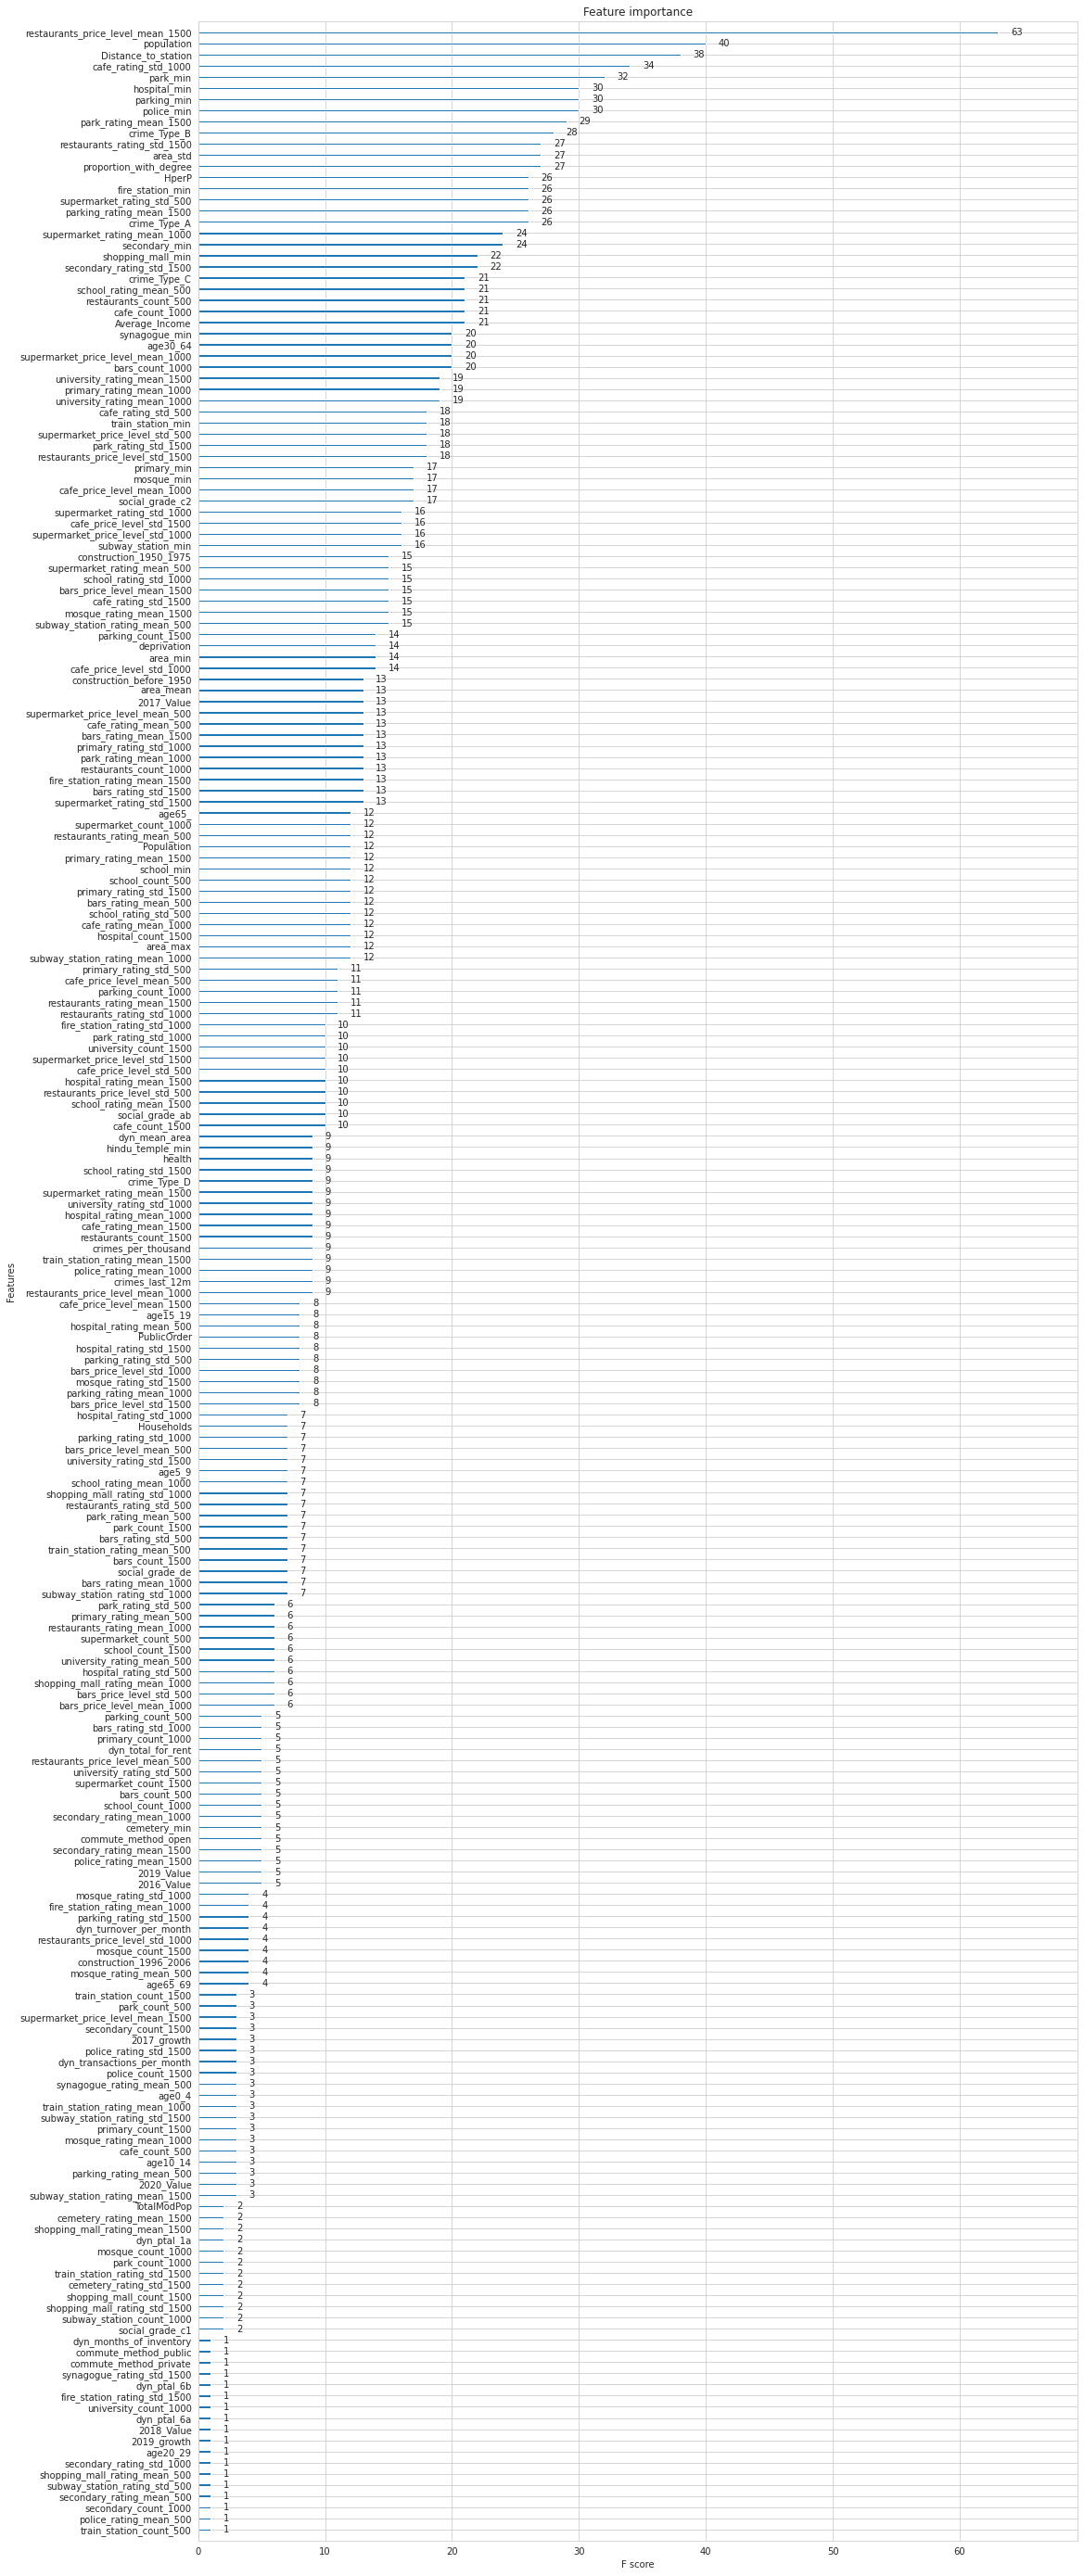

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,50))

xg.plot_importance(xgb_r, ax,importance_type='weight')

The following kwargs were not used by contour: 'row'
No handles with labels found to put in legend.


Text(0.5, 32.99999999999995, 'real price')

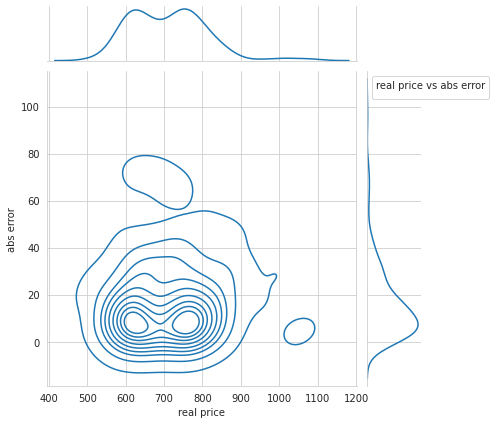

In [ ]:
h=sns.jointplot(x = test_y, y = np.abs(test_y-pred_test), kind ='kde', row="day")
plt.legend(title='real price vs abs error')
h.ax_joint.set_ylabel('abs error')
h.ax_joint.set_xlabel('real price')

No handles with labels found to put in legend.


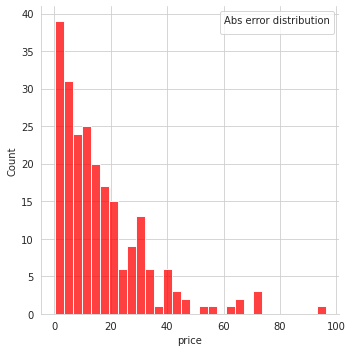

In [ ]:
sns.set_style('whitegrid')
h=sns.displot(np.abs(test_y-pred_test), kde = False, color ='red', bins = 30)
plt.legend(title='Abs error distribution')

In [ ]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score


def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance


In [ ]:
def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

In [ ]:
def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

In [ ]:
def plot_importantes_features(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots(figsize=(20,50))
    
    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

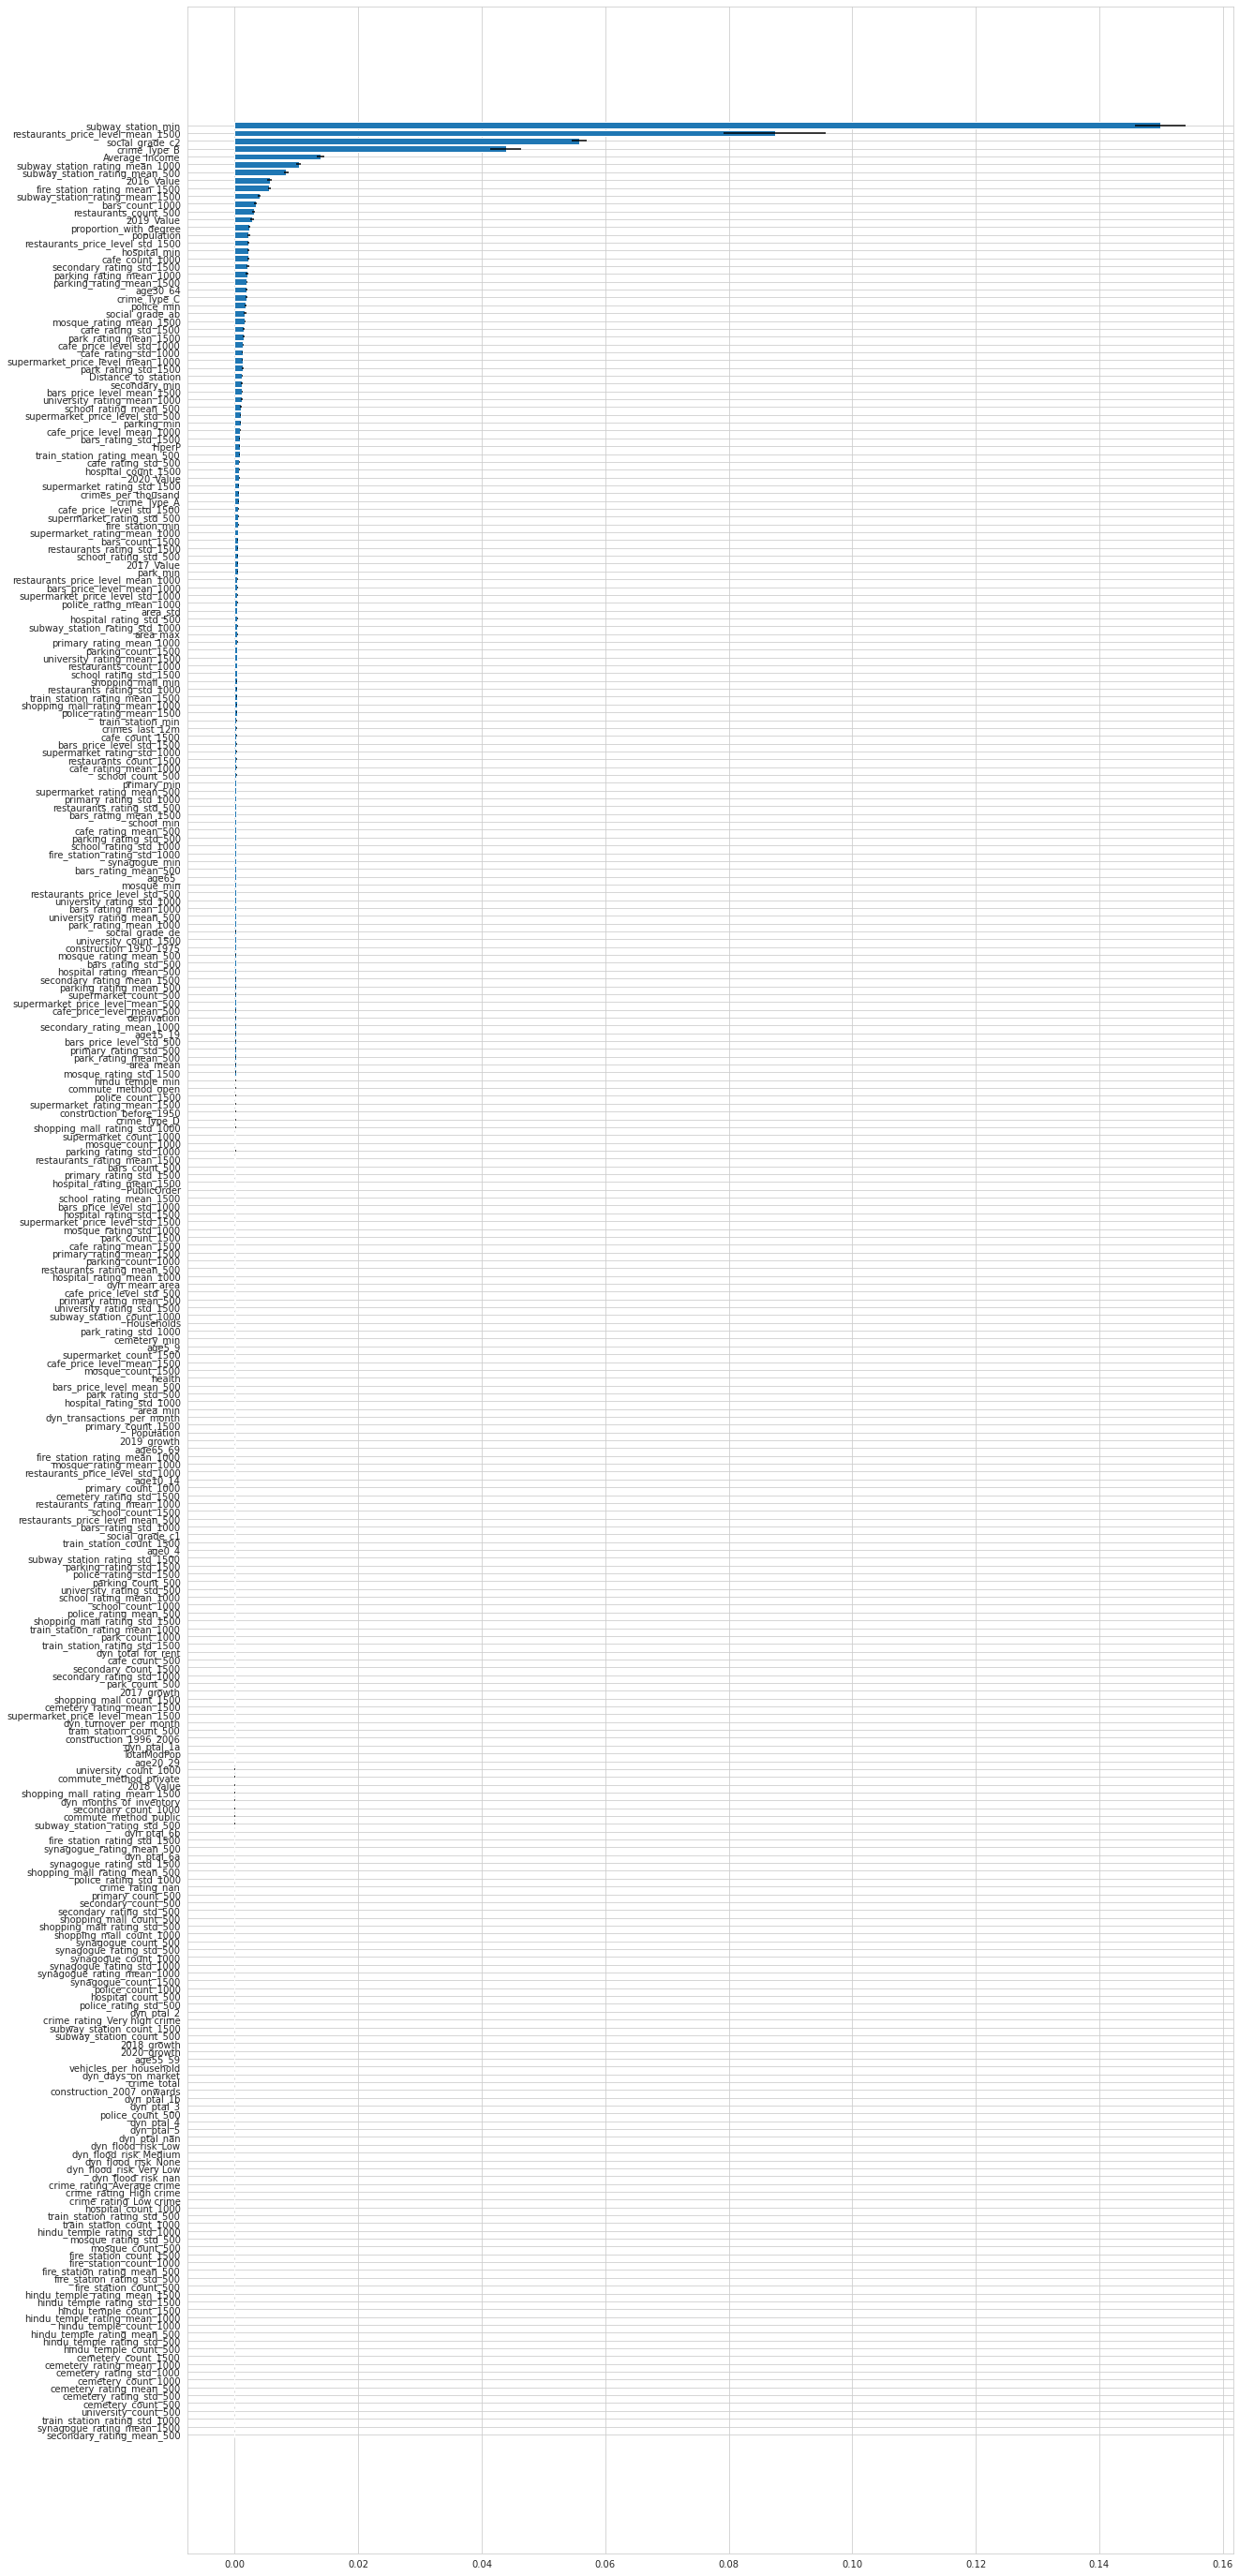

In [ ]:
perm_importance_result_train = permutation_importance(model, train_X, train_y, n_repeats=10)

plot_importantes_features(perm_importance_result_train, train_X.columns)